# SchW-BERT-GAN 事前学習
- データセットの前処理を行い，バッチ生成器を作成
- ハイパーパラメータを記入した設定ファイルを作成
- ConditionalBertBodyモジュールの定義
- 事前学習フレームワークと事前学習モジュールの作成
- 事前学習の実行と結果の表示・モデルの保存

In [1]:
import os, copy, time, math, json, random
visible_devices = [3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import Dataset, random_split
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from utils import Timer, show_model, grid_plot
from bundle import Bundle
from preprocess.original import load_bundle_list

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

20/32 cpus are available.


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

dataset_dir = os.path.join(base_dir, "theorytab")
input_csv = os.path.join(dataset_dir, "theorytab.csv")
input_dir = os.path.join(dataset_dir, "pianoroll")

models_dir = os.path.join(schwbert_dir, "models", "theorytab")
pretrained_dir = os.path.join(models_dir, "pretrained")

for directory in [schwbert_dir, models_dir, pretrained_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# ハイパーパラメータを記入した設定辞書を作成

In [ ]:
melody_oct = 2
melody_range = melody_oct * 12
config = {
    'nickname': "schwbert_most_masked",
    'step_num': 768,
    'beat_resolution': 12,
    'beats_in_bar': 4,
    'bar_num': 16,
    'include_rest_to_area': False,
    'melody_pitch_range': [0, melody_range],
    'melody_rest_id': melody_range + 0,
    'melody_mask_id': melody_range + 1,
    'melody_pad_id': melody_range + 2,
    'melody_vocab_size': melody_range + 3,
    'chord_pad_id': 12,
    'chord_vocab_size': 13,
    
    'embedding_size': 64,
    'hidden_size': 128,
    'intermediate_size': 128 * 4,
    'attention_layer_num': 2,
    'attention_head_num': 1,
    'share_all_bert_params': False,
    
    'dropout_prob': 0.20,
    'adam_lr': 1e-4,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'pre_mnp_aug': 2,
    'pre_msp_aug': 0,
    'pre_mnp_rate': 0.90,
    'pre_mnp_mask_rate': 0.80,
    'pre_mnp_random_rate': 0.10,
    'pre_mnp_keep_rate': 0.10,
}
config = AttrDict(config)
for item in config.items():
    print(f"{item[0]}: {item[1]}")

In [3]:
melody_oct = 2
melody_range = melody_oct * 12
config = {
    'nickname': "schwbert_all_masked",
    'step_num': 768,
    'beat_resolution': 12,
    'beats_in_bar': 4,
    'bar_num': 16,
    'include_rest_to_area': False,
    'melody_pitch_range': [0, melody_range],
    'melody_rest_id': melody_range + 0,
    'melody_mask_id': melody_range + 1,
    'melody_pad_id': melody_range + 2,
    'melody_vocab_size': melody_range + 3,
    'chord_pad_id': 12,
    'chord_vocab_size': 13,
    
    'embedding_size': 64,
    'hidden_size': 128,
    'intermediate_size': 128 * 4,
    'attention_layer_num': 2,
    'attention_head_num': 1,
    'share_all_bert_params': False,
    
    'dropout_prob': 0.20,
    'adam_lr': 1e-4,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'pre_mnp_aug': 10,
    'pre_msp_aug': 0,
    'pre_mnp_rate': 1.0,
    'pre_mnp_mask_rate': 1.0,
    'pre_mnp_random_rate': 0.0,
    'pre_mnp_keep_rate': 0.0,
}
config = AttrDict(config)
for item in config.items():
    print(f"{item[0]}: {item[1]}")

nickname: schwbert_all_masked
step_num: 768
beat_resolution: 12
beats_in_bar: 4
bar_num: 16
include_rest_to_area: False
melody_pitch_range: [0, 24]
melody_rest_id: 24
melody_mask_id: 25
melody_pad_id: 26
melody_vocab_size: 27
chord_pad_id: 12
chord_vocab_size: 13
embedding_size: 64
hidden_size: 128
intermediate_size: 512
attention_layer_num: 2
attention_head_num: 1
share_all_bert_params: False
dropout_prob: 0.2
adam_lr: 0.0001
adam_beta1: 0.9
adam_beta2: 0.999
pre_mnp_aug: 10
pre_msp_aug: 0
pre_mnp_rate: 1.0
pre_mnp_mask_rate: 1.0
pre_mnp_random_rate: 0.0
pre_mnp_keep_rate: 0.0


# 前処理済みのtheorytabデータセットからバッチ生成器を作成
DataLoaderとDatasetの扱い方はQiitaを[参照](https://qiita.com/takurooo/items/e4c91c5d78059f92e76d)

その前にまずは前処理済みデータをロード

In [4]:
with Timer():
     bundle_list = load_bundle_list(input_csv, input_dir, core_num=core_num)

start preprocessing...
unpacking result bundles list...
Preprocessing Finished!
load 17396 bundles
0 error(s) occured
Timer: 37.715686


学習の度にデータが変わるのはやっぱりよくないので固定にする  
しかし，データもそんなに多くないので，同じ譜面に対して複数のマスクを行ったデータセットを作成し，水増しする

In [5]:
seed=None

def make_mnp_bundle(bundle):
    if seed is not None:
        random.seed(seed)
    
    include_rest = config.include_rest_to_area
    target_rate = config.pre_mnp_rate
    mask_rate = config.pre_mnp_mask_rate
    random_rate = config.pre_mnp_random_rate
    keep_rate = config.pre_mnp_keep_rate

    max_predict_steps = int(config.step_num * target_rate)
    hidden_size = config.hidden_size
    bar_res = config.beats_in_bar * config.beat_resolution
    melody_vocab_size = config.melody_vocab_size
    mask_id = config.melody_mask_id
    pad_id = config.melody_pad_id

    melody_pitches = list(range(*config.melody_pitch_range))
    if include_rest:
        melody_pitches.append(config.melody_rest_id)
    to_one_hot = np.eye(melody_vocab_size)
    
    steps = np.zeros(max_predict_steps)
    weights = np.zeros([max_predict_steps, 1])
    labels = np.zeros([max_predict_steps, melody_vocab_size], dtype=int)

    # ステップを音符ごとに分けたものを取得
    note_areas = bundle['meta']['note_areas']

    # 音符のIDをランダムにならべかえる
    note_num = len(note_areas)
    target_note_candidates = list(range(note_num))
    random.shuffle(target_note_candidates)

    # マスク処理の対象となる音符を選ぶ．
    # このとき，合計ステップ数がmax_predict_stepsを超えないようにする
    song_step_num = bar_res * bundle['meta']['original_bars']
    limit_predict_steps = int(song_step_num * target_rate)
    target_note_areas = []
    target_step_num = 0
    for target_note_id in target_note_candidates:
        target_note_area = note_areas[target_note_id]
        if target_step_num + len(target_note_area) <= limit_predict_steps:
            target_note_areas.append(target_note_area)
            target_step_num += len(target_note_area)

    # 処理の対象となったステップのリスト
    # なんとなくソートしておく
    target_steps = []
    for note_area in target_note_areas:
        target_steps += list(note_area)
    target_steps.sort()
    active_step_len = len(target_steps)
    steps[:active_step_len] = target_steps

    # max_predict_stepsにサイズを合わせるためのweightを用意
    # lossの計算時，padのstepに0, そうでないstepに1をかける
    weights[:active_step_len, :] = 1

    # 処理の対象となったステップごとの正解ラベル
    labels[:active_step_len, :] = bundle['melody'][target_steps]
    labels[active_step_len:, pad_id] = 1

    # 対象音符数， マスクされる音符の数， ランダムに変更される音符の数, そのままにされる音符の数を取得
    target_note_num = len(target_note_areas)
    random_num = math.ceil(target_note_num * random_rate)
    keep_num = math.ceil(target_note_num * keep_rate)
    masked_num = target_note_num - random_num - keep_num

    # mask対象の音符をmaskにする
    masked_note_areas = target_note_areas[:masked_num] # (音符, ステップ)の二次元配列
    for area in masked_note_areas:
        bundle['melody'][list(area)] = to_one_hot[mask_id]

    # random対象の音符をランダムに入れ替え
    random_note_areas = target_note_areas[masked_num:masked_num+random_num]
    for area in random_note_areas:
        random_pitch = random.choice(melody_pitches)
        bundle['melody'][list(area)] = to_one_hot[random_pitch]

    # 作成したMNP用データをmetaへ保存
    bundle['meta']['mnp'] = {
        'steps': steps,
        'weights': weights,
        'labels': labels,
    }
        
    return bundle

MNPは難しいのでMasked Step Predictionにした方がいいかな？  
繰り返しを捉えるのは得意みたいなので連続的にマスクしてしまうよりステップ単位で見てやった方が良いかも？  
stepもまぁNoteではあるのでデータの呼称はこれまで通りmnpにするが，関数名はmspにしておく

In [6]:
def make_msp_bundle(bundle, seed=None):
    if seed is not None:
        random.seed(seed)
    
    include_rest = config.include_rest_to_area
    target_rate = config.pre_mnp_rate
    mask_rate = config.pre_mnp_mask_rate
    random_rate = config.pre_mnp_random_rate
    keep_rate = config.pre_mnp_keep_rate

    max_predict_steps = int(config.step_num * target_rate)
    hidden_size = config.hidden_size
    bar_res = config.beats_in_bar * config.beat_resolution
    melody_vocab_size = config.melody_vocab_size
    mask_id = config.melody_mask_id
    pad_id = config.melody_pad_id

    melody_pitches = list(range(*config.melody_pitch_range))
    if include_rest:
        melody_pitches.append(config.melody_rest_id)
    to_one_hot = np.eye(melody_vocab_size, dtype=int)
    
    steps = np.zeros(max_predict_steps, dtype=int)
    weights = np.zeros([max_predict_steps, 1], dtype=int)
    labels = np.zeros([max_predict_steps, melody_vocab_size], dtype=int)

    # マスク処理の対象となる音符をランダムに選ぶ．
    # このとき，合計ステップ数がlimit_predict_stepsを超えないようにする
    song_step_num = bar_res * bundle['meta']['original_bars']
    limit_predict_steps = int(song_step_num * target_rate)
    step_cands = list(range(song_step_num))
    random.shuffle(step_cands)
    target_steps = []
    pitches = np.where(bundle['melody'])[1]
    for step in step_cands:
        if pitches[step] in melody_pitches:
            target_steps.append(step)
        if len(target_steps) >= limit_predict_steps:
            break
    
    # なんとなくソートしておく
    target_steps.sort()
    
    # 処理の対象となったステップのリスト
    active_step_len = len(target_steps)
    steps[:active_step_len] = target_steps

    # max_predict_stepsにサイズを合わせるためのweightを用意
    # lossの計算時，padのstepに0, そうでないstepに1をかける
    weights[:active_step_len, :] = 1

    # 処理の対象となったステップごとの正解ラベル
    labels[:active_step_len, :] = bundle['melody'][target_steps]
    labels[active_step_len:, pad_id] = 1

    # 対象音符数， マスクされる音符の数， ランダムに変更される音符の数, そのままにされる音符の数を取得
    random_num = math.ceil(active_step_len * random_rate)
    keep_num = math.ceil(active_step_len * keep_rate)
    masked_num = active_step_len - random_num - keep_num
    processed_steps = random.sample(target_steps, masked_num + random_num)

    # mask対象の音符をmaskにする
    bundle['melody'][processed_steps[:masked_num]] = to_one_hot[mask_id]

    # random対象の音符をランダムに入れ替え
    random_ids = random.choices(melody_pitches, k=random_num)
    bundle['melody'][processed_steps[masked_num:]] = to_one_hot[random_ids]
        
    # 作成したMNP用データをmetaへ保存
    bundle['meta']['mnp'] = {
        'steps': steps,
        'weights': weights,
        'labels': labels,
    }
        
    return bundle

In [7]:
with Timer():
    pool = Pool(core_num)
    msp_bundle_list = []
    for i in range(config.pre_msp_aug):
        msp_bundle_list += bundle_list
    if len(msp_bundle_list) > 0:
        msp_bundle_list = pool.map(make_msp_bundle, msp_bundle_list)
    
    mnp_bundle_list = []
    for i in range(config.pre_mnp_aug):
        mnp_bundle_list += bundle_list
    if len(mnp_bundle_list) > 0:
        mnp_bundle_list = pool.map(make_mnp_bundle, mnp_bundle_list)
    
    aug_bundle_list = msp_bundle_list + mnp_bundle_list

pool.close()

Timer: 1162.433100


target length: 50

labels: [12 12 12 12 12 12  9  9  9  9  9  9 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]

steps: [ 66  67  68  69  70  71  90  91  92  93  94  95 150 151 152 153 154 155
 156 157 158 159 160 161 204 205 206 207 208 209 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307]


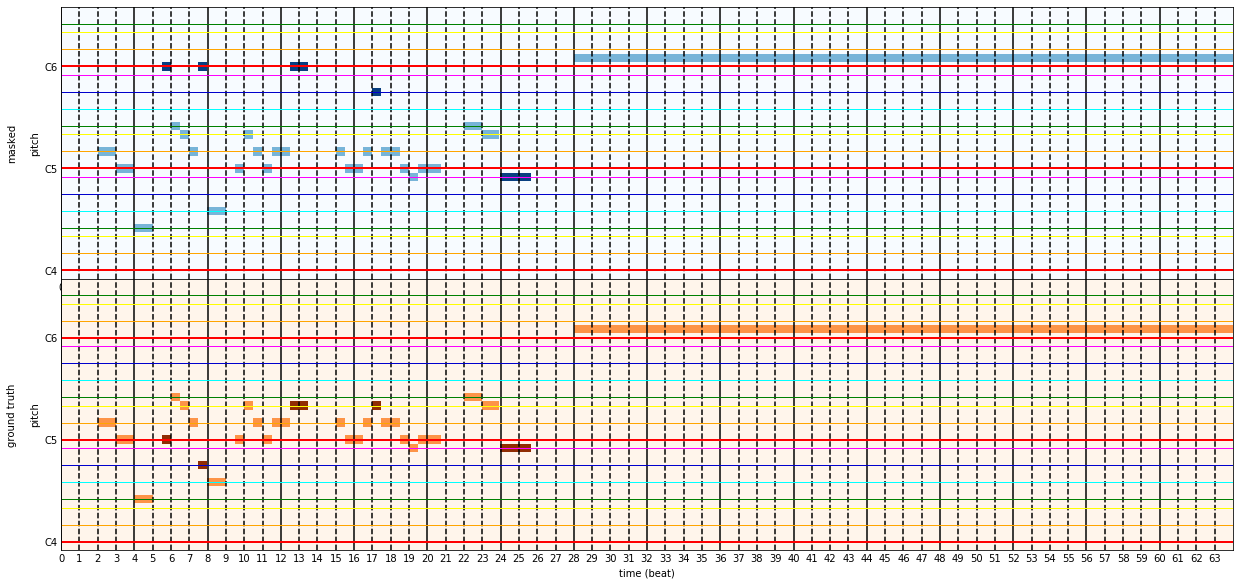

In [11]:
bundle_id = -1

bundle_dict = aug_bundle_list[bundle_id]
bundle = Bundle(bundle_dict)

bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
steps = bundle.meta.mnp.steps.astype(int)
labels = bundle.meta.mnp.labels.astype(int)
weights = bundle.meta.mnp.weights.astype(int)

ppr = bundle.get_ppr()

weight_len = weights.sum()
print("target length:", weight_len)

ppr.assign_constant(60)
ppr.tracks[1] = ppr.tracks[0].copy()

# masked
ppr.tracks[0].pianoroll[steps[:weight_len]] *= 2
ppr.tracks[0].name = "masked"

# ground truth
label_ids = np.argmax(labels, axis=-1)
print("\nlabels:", label_ids)
print("\nsteps:", steps[:weight_len])
offset = bundle.meta.melody_offset
ppr.tracks[1].pianoroll[steps[:weight_len]] *= 0
ppr.tracks[1].pianoroll[steps[:weight_len], offset + label_ids[:weight_len]] = 120
ppr.tracks[1].name = "ground truth"

grid_plot(ppr)

DataLoaderへ渡すTheorytabDatasetを作成

In [8]:
class TheorytabDataset(Dataset):
    def __init__(self, bundles):
        self.data = bundles
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        melody = self.data[idx]['melody']
        chord = self.data[idx]['chord']    
        meta = self.data[idx]['meta']
        return melody, chord, meta
    
    def split(self, rates, shuffle=False):
        assert(sum(rates) == 1.)
        
        all_data_ids = list(range(len(self)))
        if shuffle:
            random.shuffle(all_data_ids)
        
        sizes = [int(len(self) * rate) for rate in rates[:-1]]
        sizes.append(len(self) - sum(sizes))
        
        partial_dataset_list = []
        last_right = 0
        for size in sizes:
            left, right = last_right, last_right+size
            last_right += size
            partial_data = [self.data[idx] for idx in all_data_ids[left:right]]
            dataset = TheorytabDataset(partial_data)
            partial_dataset_list.append(dataset)
        
        return partial_dataset_list

torchのDataLoaderはmeta辞書の中身をバッチで結合して1つの辞書にしてきやがる  
バッチにしたときmeta辞書はindexと対応するようにしたいので，DataLoaderを自作

In [9]:
class TheorytabDataLoader:
    def __init__(self, theorytab_dataset, batch_size, shuffle=False):
        self.dataset = theorytab_dataset
        self.idx_list = list(range(len(self.dataset)))
        assert(batch_size >= 1)
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def make_batch(self, melody_batch, chord_batch, meta_batch):
        # 一度np.arrayをかませてからLongTensorに渡すと爆速になったので採用
        # しかしバッチサイズが1000くらい大きくならないと同じ速度にならない
        melody_batch, chord_batch = np.array(melody_batch), np.array(chord_batch)
        
        if 'mnp' in meta_batch[0]:
            batch = {
                'melody': torch.FloatTensor(melody_batch),
                'chord': torch.FloatTensor(chord_batch),
                'mnp_steps': torch.LongTensor(np.array([meta['mnp']['steps'] for meta in meta_batch])),
                'mnp_weights': torch.ShortTensor(np.array([meta['mnp']['weights'] for meta in meta_batch])),
                'mnp_labels': torch.ShortTensor(np.array([meta['mnp']['labels'] for meta in meta_batch])),
                'meta': meta_batch # AttrDictを通すとlistではなくtupleになるので注意
            }
        else:
            batch = {
                'melody': torch.FloatTensor(melody_batch),
                'chord': torch.FloatTensor(chord_batch),
                'meta': meta_batch # AttrDictを通すとlistではなくtupleになるので注意
            }
        return AttrDict(batch)
    
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.idx_list)

        melody_batch, chord_batch, meta_batch = [], [], []
        for idx in self.idx_list:
            melody, chord, meta = self.dataset[idx]
            melody_batch.append(melody)
            chord_batch.append(chord)
            meta_batch.append(meta)

            if len(melody_batch) >= self.batch_size:
                yield self.make_batch(melody_batch, chord_batch, meta_batch)
                melody_batch, chord_batch, meta_batch = [], [], []

        if melody_batch and chord_batch and meta_batch:
            yield self.make_batch(melody_batch, chord_batch, meta_batch)
    
    def __call__(self):
        """
        何でもいいからバッチが欲しい時使う
        ジェネレータを返すわけではないので注意
        """
        return next(self.__iter__())

以上のDatasetとDataLoaderはdataloader.pyからimportできるようにした

In [10]:
dataset = TheorytabDataset(aug_bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=100, shuffle=True)
print(len(dataloader))

1740


In [11]:
train_dataset, val_dataset, test_dataset = dataset.split([0.8, 0.17, 0.03], shuffle=True)
print("train size :", len(train_dataset))
print("val   size :", len(val_dataset))
print("test  size :", len(test_dataset))

train size : 139168
val   size : 29573
test  size : 5219


動作確認

In [12]:
batch_list = dataloader()
batch = batch_list[0]
print(batch.melody.type())
print(batch.melody.size())
print(batch.chord.type())
print(batch.chord.size())
print(batch.mnp_steps.size())
print(batch.mnp_weights.size())
print(batch.mnp_labels.size())
print(len(batch.meta))

torch.FloatTensor
torch.Size([2, 768, 27])
torch.FloatTensor
torch.Size([2, 768, 13])
torch.Size([2, 115])
torch.Size([2, 115, 1])
torch.Size([2, 115, 27])
2


In [ ]:
batch_id = 0
bundle = Bundle({
    "melody": batch.melody[batch_id].numpy(),
    "chord": batch.chord[batch_id].numpy(),
    "meta": batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr)

# ConditionalBertBodyの作成
事前学習を行い，他のタスク用モジュールへ連結するためのbodyモジュール  
コードは[ここ](https://nbviewer.jupyter.org/github/fuurin/pytorch_advanced/blob/master/Chapter8/8-2_bert_base.ipynb)を参照

実装するものはこれ  
ConditioningはEmbeddingsで行い，あとは普通のTransformer  
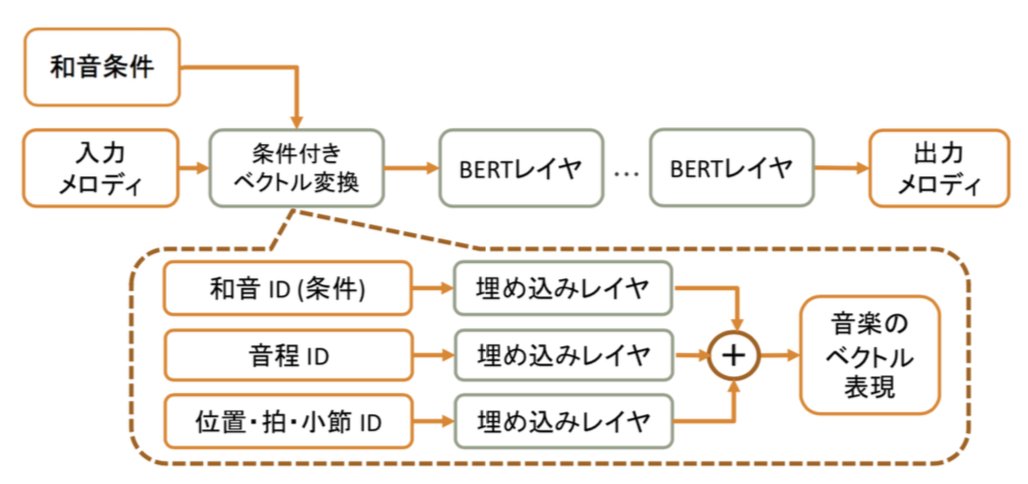  
BertLayerにSAで条件付けする奴は，コード条件がメロディを食いつぶす上異常にメモリを食うので没

基本となるBERT Layerモジュールはこれ  
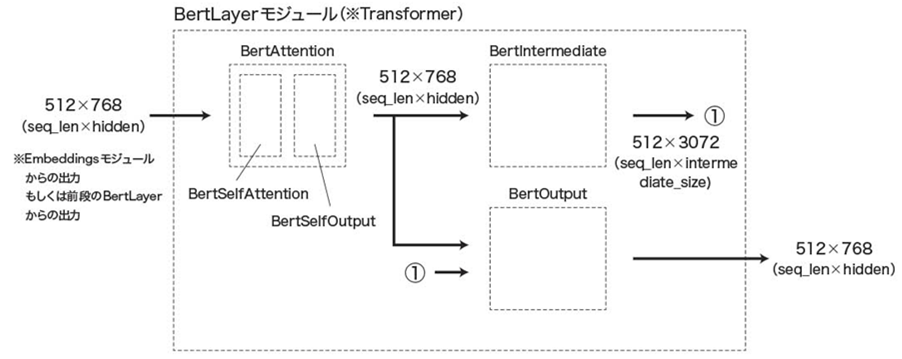

画像： 書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)  
公式リポジトリ https://github.com/YutaroOgawa/pytorch_advanced

#### Conditional Bertにするための変更点
Embeddingsにコードを追加

ALBERTのFactorized Embeddingを適用  
埋め込みサイズを一旦小さくし，hidden_sizeへの全結合層で再構成する  
これにより，BERTなら30000 * 1000 = 30M が30000 * 128 + 128 * 1000 = 3Mと大きくパラメータ数を減らせる  
ここでは一旦12へ埋め込んだ後hidden_sizeへ展開する: 633216 -> 76720

In [12]:
def count_params(*modules, requires_grad=True):
    param_nums = []
    for module in modules:
        for param in module.parameters():
            if param.requires_grad and requires_grad:
                param_nums.append(param.numel())
    return sum(param_nums)

count_paramsはutilsへ保存した

## ConditionalEmbeddingsの実装
- input_embedding: ピッチID/コードベクトルのEmbedding
- condition_embedding: この場合コードのEmbedding
- step_embedding: range(seq_len)を与えるEmbedding
- beat_embedding: 0から始まる拍番号を各ステップへ与える
- bar_embedding: 0から始まる小節番号を各ステップへ与える

ConditionalBertAttentionはコード条件でメロディをすりつぶすので，埋め込み層のみで条件付けする  
padの部分の埋め込みベクトルはすべて0にする．  

In [13]:
class VecSeqEmbedding(nn.Module):
    def __init__(self, input_size, output_size, padding_idx=None):
        super(VecSeqEmbedding, self).__init__()
        self.pad_id = padding_idx
        self.embedding = nn.Linear(input_size, output_size, bias=False)
    
    def forward(self, input_seq):
        if self.pad_id is not None:
            input_seq[:, :, self.pad_id] = 0
        embedded = self.embedding(input_seq)
        return embedded
    
class ConditionalEmbeddings(nn.Module):
    def __init__(self, config, input_vocab_size, condition_vocab_size, input_pad_id=None):
        super(ConditionalEmbeddings, self).__init__()
        
        self.pad_id = input_pad_id
        self.emb_size = config.embedding_size
        self.hidden_size = config.hidden_size
        self.beat_res = config.beat_resolution
        self.bar_num = config.bar_num
        self.beats_in_bar = config.beats_in_bar
        self.bar_step_num = self.beats_in_bar * self.beat_res
        self.step_num = self.bar_step_num * self.bar_num
        
        # 各種埋め込み層
        self.input_embedding = VecSeqEmbedding(input_vocab_size, self.emb_size)
        self.condition_embedding = VecSeqEmbedding(condition_vocab_size, self.emb_size)
        self.step_embedding = nn.Embedding(self.bar_step_num, self.emb_size)
        self.beat_embedding = nn.Embedding(self.beats_in_bar, self.emb_size)
        self.bar_embedding = nn.Embedding(self.bar_num, self.emb_size)
        
        # 後処理用の層
        self.concat_dense = nn.Linear(self.emb_size*5, config.hidden_size)    
        self.post = nn.Sequential(
            LayerNorm(config.hidden_size, eps=1e-8),
            nn.Dropout(config.dropout_prob, inplace=True)
        )
        
        # 位置関係のID列は固定
        all_step_ids = torch.arange(self.step_num, dtype=torch.float32)
        self.step_ids = (all_step_ids % self.bar_step_num).type(torch.long)
        self.beat_ids = torch.floor((all_step_ids % self.bar_step_num) / self.beat_res).type(torch.long)
        self.bar_ids = torch.floor(all_step_ids / self.bar_step_num).type(torch.long)
        
    def concat_fixed_embeddings(self, input_emb, condition_emb):
        device = input_emb.device
        batch_size = len(input_emb)

        # 埋め込みベクトルを作成
        step_emb = self.step_embedding(self.step_ids.to(device)).repeat(batch_size, 1, 1)
        beat_emb = self.beat_embedding(self.beat_ids.to(device)).repeat(batch_size, 1, 1)
        bar_emb = self.bar_embedding(self.bar_ids.to(device)).repeat(batch_size, 1, 1)
        
        # 連結 & サイズ合わせ
        embeddings = torch.cat((input_emb, condition_emb, step_emb, beat_emb, bar_emb),-1)
        # embeddings = torch.cat((input_emb, condition_emb, step_emb),-1)
        embeddings = self.concat_dense(embeddings)
        
        return embeddings
    
    def forward(self, input_vecs, condition_vecs):
        input_emb = self.input_embedding(input_vecs)
        condition_emb = self.condition_embedding(condition_vecs)
        embeddings = self.concat_fixed_embeddings(input_emb, condition_emb)
        embeddings = self.post(embeddings)
        
        if self.pad_id is not None:
            is_not_pad = (input_vecs[:, :, self.pad_id] == 0).unsqueeze(-1)
            embeddings = embeddings * is_not_pad
            
        return embeddings

動作確認

In [14]:
device = torch.device("cuda")
batch = dataloader()

print(batch.melody.shape)
print(batch.chord.shape)

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size, config.chord_vocab_size,
                     config.melody_pad_id).to(device)

with Timer():
    conditional_emb = conditional_embeddings(batch.melody.to(device), batch.chord.to(device))

with Timer():
    conditional_emb.mean().backward()

print("conditional emb shape:", conditional_emb.shape)
print("# of parameter(melody + chord):", count_params(conditional_embeddings))

torch.Size([100, 768, 26])
torch.Size([100, 768, 13])
Timer: 0.104854
Timer: 0.008224
conditional emb shape: torch.Size([100, 768, 128])
# of parameter(melody + chord): 30528


## BertAttentionモジュールの実装
以下のサブネットワークを持つ
- BertAttention: Self-Attentionを計算
    - Multi-Head: 1, 2, 4, 8, とりあえず4から試すか
    - ここでpadをかける
- BertIntermediate: Self-Attentionの出力を全結合層で処理
    - 全結合層の活性化関数にGELU（Gaussian error Linear Unit, 入力0付近の出力が滑らか)を使う
- BertOutput: BertAttentionとBertIntermediateの出力を足し算

### BertAttentionモジュールの作成
次のサブモジュールからなる
- attn(BertSelfAttention)
- output(BertOutput)

In [14]:
class BertSelfAttention(nn.Module):
    def __init__(self, config, dropout=False):
        super(BertSelfAttention, self).__init__()
        
        self.hidden_size = config.hidden_size # 24
        self.attention_head_num = config.attention_head_num # 4
        self.attention_head_size = self.hidden_size // self.attention_head_num # 6
        
        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(self.hidden_size, self.hidden_size)
        self.key = nn.Linear(self.hidden_size, self.hidden_size)
        self.value = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.softmax = nn.Softmax(dim=-1)
        
        # bottleneck
        if dropout:
            self.dropout = nn.Dropout(config.dropout_prob, inplace=True)
        else:
            self.dropout = None
        
    def separate_into_heads(self, single):
        # multi-head attention用にテンソルの形を変換
        # [batch, steps, hidden] -> [batch, head_num, steps, head_size]
        multi_shape = single.size()[:-1] + (self.attention_head_num, self.attention_head_size)
        multi = single.view(*multi_shape).permute(0, 2, 1, 3)
        return multi
    
    def extend_pad(self, pad, paded_value=-1e9):
        if self.attention_head_num > 1:
            # multi-head attention用にpadの形を(batch, 1, 1, step_num)にする
            extended_pad = pad.unsqueeze(1).unsqueeze(2) # multi-headに次元を対応
        else:
            # single attention用にpadの形を(batch, 1, step_num)にする
            extended_pad = pad.unsqueeze(1)
        extended_pad = (1.0 - extended_pad) * paded_value
        extended_pad = extended_pad.to(dtype=torch.float32)
        return extended_pad
    
    def marge_heads(self, multi):
        # multi-head attentionに分離したテンソルの形を元に戻す
        # [batch, head_num, steps, head_size] -> [batch, steps, hidden]
        multi = multi.permute(0, 2, 1, 3).contiguous()
        single_shape = multi.size()[:-2] + (self.hidden_size,)
        single = multi.view(*single_shape)
        return single
    
    def forward(self, hidden_states, pad, get_probs=False):
        
        # 入力を全結合層で特徴量変換(分岐前)
        query = self.query(hidden_states)
        key = self.key(hidden_states)
        value = self.value(hidden_states)
        
        # multi-head Attentionとして分岐
        if self.attention_head_num > 1:
            query = self.separate_into_heads(query)
            key = self.separate_into_heads(key)
            value = self.separate_into_heads(value)
        
        # 特徴量同士の類似度を求める
        score = torch.matmul(query, key.transpose(-1, -2))
        score = score / math.sqrt(self.attention_head_size) # Scaled Dot-Product Attention
        
        # マスクをかける
        # 足し算なのは，attention_padに0か-infが入っているため
        # -infはsoftmax正規化したときに0になる
        score = score + self.extend_pad(pad)
        
        # AttentionMapの正規化とドロップアウト
        prob = self.softmax(score)
        if self.dropout is not None:
            prob = self.dropout(prob)
        
        # Attenton Mapをvalueに掛け算
        context = torch.matmul(prob, value)
        
        # multi-head Attentionの出力を結合
        if self.attention_head_num > 1:
            context = self.marge_heads(context)
        
        if get_probs:
            return context, prob
        else:
            return context

In [15]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob, inplace=True)
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.norm(hidden_states + input_tensor)
        return hidden_states

In [16]:
class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.attn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, input_pad, get_probs=False):
        if get_probs:
            output, probs = self.attn(input_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor)
            return output, probs
        else:
            output = self.attn(input_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor)
            return output

In [17]:
def make_pad(vecs, pad_id):
    return (vecs[:, :, pad_id] == 0).to(torch.float32)

動作確認  
よくわかんないけど，pdbをattentionの中に入れるとMemReporterが8,768,768のテンソルを認識して使用メモリが大きくなったりする...  
とりあえずペンディングで

In [23]:
device = torch.device('cuda')
batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)

print(batch.melody.shape)
print(batch.chord.shape)

input_pad = make_pad(batch.melody, config.melody_pad_id).to(device)

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size,
                     config.chord_vocab_size,
                     config.melody_pad_id).to(device)
conditional_emb = conditional_embeddings(batch.melody, batch.chord)

attention = BertAttention(config).to(device)

get_probs=True
if get_probs:
    with Timer("forward"):
        output, probs = attention(conditional_emb, input_pad, get_probs=get_probs)
    print("output shape:", output.shape)
    print("probs shape:", probs.shape)
else:
    output = attention(conditional_emb, input_pad, get_probs=get_probs)
    print("output shape:", output.shape)

with Timer("backward"):
    output.mean().backward()

torch.Size([100, 768, 27])
torch.Size([100, 768, 13])
forward: 0.002836
output shape: torch.Size([100, 768, 128])
probs shape: torch.Size([100, 768, 768])
backward: 0.004796


### BertIntermediateモジュールの実装

In [18]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
    
    def forward(self, hidden_states):
        hidden_states = self.intermediate(hidden_states)
        return F.gelu(hidden_states)

### BertOutputモジュールの実装

In [19]:
class BertOutput(BertSelfOutput):
    def __init__(self, config):
        super(BertOutput, self).__init__(config)        
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)

### BertLayerモジュールの実装

In [20]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attn = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(self, input_tensor, input_pad, get_probs=False):
        if get_probs:
            output, probs = self.attn(input_tensor, input_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output, probs
        else:
            output = self.attn(input_tensor, input_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output

動作確認

In [28]:
device = torch.device('cuda')
batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)

print(batch.melody.shape)
print(batch.chord.shape)

input_pad = make_pad(batch.melody, config.melody_pad_id).to(device)

attention = BertLayer(config).to(device)

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size,
                     config.chord_vocab_size,
                     config.melody_pad_id).to(device)
conditional_emb = conditional_embeddings(batch.melody, batch.chord)

get_probs=True
if get_probs:
    with Timer():
        output, probs = attention(conditional_emb, input_pad, get_probs=get_probs)
    print("output shape:", output.shape)
    print("probs shape:", probs.shape)
else:
    output = attention(conditional_emb, input_pad, get_probs=get_probs)
    print("output shape:", output.shape)

with Timer():
    output.mean().backward()

torch.Size([100, 768, 27])
torch.Size([100, 768, 13])
Timer: 0.002436
output shape: torch.Size([100, 768, 128])
probs shape: torch.Size([100, 768, 768])
Timer: 0.003906


### ConditionalBertStackモジュールの実装
Embeddingとは分離してパラメータを保存したいため，Stackの部分をモジュール化  
padはidsからつくるため，bodyで作る

In [21]:
class BertStack(nn.Module):
    def __init__(self, config):
        super(BertStack, self).__init__()
        self.layer_num = config.attention_layer_num    
        self.share_all_params = config.get("share_all_bert_params", False)
        if self.share_all_params:
            self.shared_attention = BertLayer(config)
            self.attention_list = range(self.layer_num)
        else:
            attention_list = [BertLayer(config) for _ in range(self.layer_num)]
            self.attention_list = nn.ModuleList(attention_list)
    
    def forward(self, input_tensor, input_pad, 
                get_all_outputs=False, get_probs=False):
        
        all_outputs, all_probs = [], []
        
        # Dの軽量版を作るとき，Attentionを使わない
        if self.attention_list is not None:
            for attention in self.attention_list:
                if self.share_all_params:
                    attention = self.shared_attention

                if get_probs:
                    input_tensor, probs = attention(
                        input_tensor, input_pad, get_probs=get_probs)
                else:
                    input_tensor = attention(
                        input_tensor, input_pad, get_probs=get_probs)

                # 12段すべての出力を見る場合
                if get_all_outputs:
                    all_outputs.append(input_tensor)
                    if get_probs:
                        all_probs.append(probs)
                
        # 最終段のAttentionのみ必要な場合
        if not get_all_outputs:
            all_outputs = input_tensor
            if get_probs:
                all_probs = probs
        
        if get_probs:
            return (all_outputs, all_probs)
        else:
            return all_outputs

## ConditionalBertBodyの実装
embeddingsがconditionalなのでこのBertBodyからConditionalになる  
embeddingsはあとでノイズ発生器に置き換えたりできるのでattention_listとは別に保存できるようにする

In [22]:
class ConditionalBertBody(nn.Module):
    def __init__(self, config, embeddings):
        super(ConditionalBertBody, self).__init__()
        self.config = config
        self.input_pad_id = config.melody_pad_id
        self.condition_pad_id = config.chord_pad_id
        self.embeddings = embeddings
        self.bert_stack = BertStack(config)
    
    def make_pad(self, input_tensor, pad_id):
        pad = (input_tensor[:, :, pad_id] == 0)
        pad = pad.to(torch.float32).to(input_tensor.device)
        return pad
    
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        embeddings = self.embeddings(input_tensor, condition_tensor)
        pad = self.make_pad(condition_tensor, self.condition_pad_id)
        stack_out = self.bert_stack(embeddings, pad, get_all_outputs, get_probs)
        return stack_out

In [23]:
class MultiGPUWrapper:
    """
    DataParallelでWrapしてもmoduleのアトリビュートにアクセスできるWrapper
    DataParallelへのアトリビュートアクセスが優先され，なければmoduleのものにアクセスする
    dirなど中身を見たいときにはthis.moduleもしくはthis.data_parallelを用いる
    """
    def __init__(self, module, device_ids=None, output_device=None, dim=0):
        self.module = module
        self.data_parallel = nn.DataParallel(self.module, device_ids, output_device, dim)
        
    def __getattr__(self, attr):
        if hasattr(self.data_parallel, attr):
            return getattr(self.data_parallel, attr)
        else:
            return getattr(self.module, attr)
    
    def __call__(self, *args, **kwargs):
        return self.data_parallel(*args, **kwargs)

ここまでのモデル定義はmodel.pyからimportできるようにした

動作確認

In [32]:
device = torch.device("cuda")

batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)
print(batch.melody.shape)
print(batch.chord.shape)

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size,
                     config.chord_vocab_size,
                     config.melody_pad_id)
body = ConditionalBertBody(config, conditional_embeddings)
body = body.to(device)

# お手軽マルチGPU
# deviceは今まで通りっぽい
# だが，DataParallelクラスにラップされているので，モジュールにアクセスするにはbody.moduleを呼ぶ
# body = MultiGPUWrapper(body)

get_probs = True
get_all_outputs = True
if get_probs:
    with Timer("forward"):
        output, probs = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
        print("probs len:", len(probs))
    print("output shape:", (output[0] if get_all_outputs else output).shape)
    print("probs shape:", (probs[0] if get_all_outputs else probs).shape)
else:
    output = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
    print("output shape:", (output[0] if get_all_outputs else output).shape)

with Timer("backward"):
    output[-1].mean().backward()

torch.Size([100, 768, 27])
torch.Size([100, 768, 13])
forward: 0.008430
output len: 2
probs len: 2
output shape: torch.Size([100, 768, 128])
probs shape: torch.Size([100, 768, 768])
backward: 0.005365


In [33]:
print("trainable params:", count_params(body))
# print(body)

trainable params: 492672


# 事前学習フレームワークと各事前学習モジュールの作成

## 事前学習フレームワークの作成
事前学習フレームワークは以下の動作が主な役割である
- body,DataLoader,事前学習クラスのリストを渡す
    - 入力データとラベルの作成
    - bodyと事前学習モジュールを連結
    - 入力データを連結モジュールへ与える
    - 出力とラベルからロスをBP

事前学習クラスは以下を持つ
- 入力データとラベルの作成関数
- 事前学習モジュールの定義関数
- 損失関数

In [24]:
class PreTrainingModel(nn.Module):
    def __init__(self, config, body):
        super(PreTrainingModel, self).__init__()
        self.config = config
        self.body = body
        self.loss_dict = {'train': [], 'val': []}
        self.acc_dict = {'train': [], 'val': []}
    
    def forward(self, batch, get_probs=False):
        if get_probs:
            body_output, probs = self.body(batch.melody, batch.chord, get_all_outputs=True, get_probs=True)
            head_output = self.forward_head(batch, body_output[-1])
            return head_output, probs
        else:
            body_output = self.body(batch.melody, batch.chord)
            head_output = self.forward_head(batch, body_output)
            return head_output
    
    def send(self, batch, device):
        raise NotImplementedError()
    
    def forward_head(self, batch, body_output):
        raise NotImplementedError()
    
    def get_loss_and_acc(self, batch, model_output):
        raise NotImplementedError()
    
    @property
    def condition_str(self):
        raise NotImplementedError()
    
    @property
    def name(self):
        return self.__class__.__name__

## 各事前学習クラスの作成
事前学習はひとまず3種類
- Masked Note Prediction (虫食い音符の穴埋め)
    - 1ステップごとではなく，音符一つごとMASKして穴埋め
    - 休符も1つの音符と数えるべき？
    - ランダムに入れ替えたり，そのままにしたりするのを1割ずつやる
- Bars Order Prediction (小節の順番を学習)
    - 全ての小節をバラバラにして元の楽曲を生成
    - 16 × 16の行列を出力させ，どの小節が何番目にあるべきかを推論
- (Chord) Condition Prediction (元のコード条件を出力メロディから推論)
    - chord ID を出力メロディから推論
    - Chordにカッコがついてるのは，テンポやジャンルといった条件が増えたときにも同様の事前学習をさせられるため

### MaskedNotePredictionの作成
音符単位でマスクしてマスクされている部分を推測する  
[MASK]トークンはファインチューニングの際には出現しないためミスマッチを作ってしまうという弱点がある．  
そこで，マスク対象となった単語を実際の[MASK]には，必ずしも置き換えないことにする．  
  
訓練データ生成器は推論に用いる全体の15%のトークンポジションをランダムに選ぶ．  
$i$番目のトークンが選ばれたとき，$i$番目のトークンを
- (1) 80%の確立で[MASK]に置き換える
- (2) 10%の確立で別のランダムな単語に置き換える
- (3) 10%の確立でそのままのトークンにしておく
    
そして，$i$番目のトークン$T_i$はオリジナルのトークンの推測に使用され，cross entropy lossで損失を得る  
  
衝撃の事実: 事前学習用のデータは固定で，イテレーションの度にマスクされる場所が変更されるわけではなかった  
今回扱うデータは自然言語並みに多様性があるわけではないのでイテレーションの度に変更するようにしてみる

とりあえず全結合2段でMNPしてみよう

マスクされるpositionの数はbundleによってまちまちである  
bertの本家コードでは，max_predictions_per_seqを導入し，この数を超えないようにtokensを選ぶ  
そして，max_predictions_per_seqに満たない部分はposition=0, id=0, weight=0とし，paddingする  
これにより，mwpヘッドへの入力をmax_predictions_per_seq個のトークンに絞る．  
padされているpositionのlossにweight=0をかけてやることで  
上記の処理でマスクされるpositionのみのlossとaccを求める  
コードは本家の[run_pretraining.py](https://github.com/google-research/bert/blob/e13c1f3459cc254f7abbabfc5a286a3304d573e4/run_pretraining.py#L277)及び[create_pretraining_data.py](https://github.com/google-research/bert/blob/0fce551b55caabcfba52c61e18f34b541aef186a/create_pretraining_data.py#L125)が参考になる

In [25]:
class GeLU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

class MaskedNotePrediction(PreTrainingModel):
    def __init__(self, config, body):
        super(MaskedNotePrediction, self).__init__(config, body)
        self.hidden_size = config.hidden_size
        self.vocab_size = config.melody_vocab_size
        self.pad_id = config.melody_pad_id
        
        self.head = nn.Sequential(
            nn.Linear(config.hidden_size, config.melody_vocab_size),
            GeLU(),
            LayerNorm(config.melody_vocab_size, eps=1e-8),  
        )

        self.log_softmax = nn.LogSoftmax(dim=0)
    
    def send(self, batch, device):
        batch.melody = batch.melody.to(device)
        batch.chord = batch.chord.to(device)
        batch.mnp_steps = batch.mnp_steps.to(device)
        batch.mnp_weights = batch.mnp_weights.to(device)
        batch.mnp_labels = batch.mnp_labels.to(device)
        return batch
    
    def forward_head(self, batch, body_output):
        # ここでloss計算対象ステップを絞る．
        # body_outputはすでに周囲の情報を考慮しており，
        # 以降のDenseではステップごとに同じ処理が行われるため，
        # targetでない入力を使う必要がない
        # body_output: [2, 765, 24], batch_steps(index): [2, 115, 24], gatherのoutput: [2, 115, 24]
        batch_steps = batch.mnp_steps.unsqueeze(-1).expand(-1, -1, self.hidden_size)
        output = torch.gather(body_output, 1, batch_steps)
        output = self.head(output)
        return output
        
    def get_loss_and_acc(self, batch, model_output, eps=1e-8):
        # トークンごとに対象かどうかをweightで選択し，CrossEntropyを求める
        # PytorchのCrossEntropyLossではこれができなそうなので，本家コードに従った処理を行う
        
        softmax_out = self.log_softmax(model_output)
        weighted_ce_loss = softmax_out * batch.mnp_labels * batch.mnp_weights
        neg_sum_loss = - weighted_ce_loss.sum()
        target_seq_len = batch.mnp_weights.sum()
        avg_loss = neg_sum_loss / (target_seq_len + eps)
        
        # model_outputの最大値とlabelからaccuracyを求める
        probs, preds = torch.max(model_output, dim=-1)
        ones, label_ids = torch.max(batch.mnp_labels, dim=-1)
        weighted_corrects = (preds == label_ids) * batch.mnp_weights.squeeze()
        correct_num = weighted_corrects.sum().to(torch.float)
        avg_acc = correct_num / (target_seq_len + eps)
                
        return avg_loss, avg_acc
    
    @property
    def condition_str(self):
        A = self.config.pre_mnp_aug
        T = self.config.pre_mnp_rate
        M = self.config.pre_mnp_mask_rate
        R = self.config.pre_mnp_random_rate
        K = self.config.pre_mnp_keep_rate
        return f"MNP:A={A}T={T}M={M}R={R}K={K}"

動作確認

In [30]:
device = torch.device('cuda')

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size,
                     config.chord_vocab_size,
                     config.melody_pad_id)
body = ConditionalBertBody(config, conditional_embeddings)
body = body.to(device)

mnp = MaskedNotePrediction(config, body)
mnp = mnp.to(device)
# mnp = MultiGPUWrapper(mnp)

with Timer("dataload"):
    batch = dataloader()
    
with Timer("send"):
    batch = mnp.send(batch, device)

with Timer("forward"):
    output, probs = mnp(batch, get_probs=True)
    
with Timer("loss acc"):
    loss, acc = mnp.get_loss_and_acc(batch, output)

print(loss, acc)

with Timer("backward"):
    loss.backward()

dataload: 0.265711
send: 0.003616
forward: 0.005508
loss acc: 0.000981
tensor(5.0434, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0297, device='cuda:0')
backward: 0.005489


### BarsOrderPredictionの作成

GANによる学習を優先

### ConditionPredictionの作成

GANによる学習を優先

# 事前学習の実行と結果の表示・保存

## モデルとconfigの保存・読込用関数を作成  
学習中に一定エポックごとに保存したいので先にこの作業をやってしまう  
あとでmelody_embはノイズ発生器に置き換えたいのでsave_bodyはembとattention_listを別々に保存する

In [26]:
def make_state_name(config, model, epoch_num):
    if issubclass(model.__class__, PreTrainingModel):
        model_name = model.name
    elif issubclass(model.__class__, MultiGPUWrapper):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__
    
    nickname = config.nickname
    E = epoch_num
    H = config.hidden_size
    I = config.intermediate_size
    A = config.attention_layer_num
    AH = config.attention_head_num
    
    state_name = f"{nickname}:{model_name}:E={E:0>3}H={H}I={I}A={A}AH={AH}"
    
    if issubclass(model.__class__, PreTrainingModel):
        state_name += model.condition_str
    
    return state_name

def save_model(config, model, epoch_num, directory):
    if issubclass(model.__class__, MultiGPUWrapper):
        model = model.module
    
    state_name = f"{make_state_name(config, model, epoch_num)}.pth"
    state_path = os.path.join(directory, state_name)
    torch.save(model.state_dict(), state_path)
    print(f"{state_name} saved")
    return state_name

def load_model(model, state_name, directory):
    file_path = os.path.join(directory, state_name)
    state_dict = torch.load(file_path)
    model.load_state_dict(state_dict)
    return model

def save_body(config, body, epoch_num, directory):
    emb_name = save_model(config, body.embeddings, epoch_num, directory)
    bert_stack_name = save_model(config, body.bert_stack, epoch_num, directory)
    return AttrDict({
        "embeddings": emb_name, 
        "bert_stack": bert_stack_name
    })

def load_body(config, directory):
    state_name_dict = config["state_names"]
    emb_name = state_name_dict['embeddings']
    bert_stack_name = state_name_dict['bert_stack']
    
    conditional_emb = ConditionalEmbeddings(config, 
                     config.melody_vocab_size, config.chord_vocab_size,
                     config.melody_pad_id)
    conditional_emb = load_model(conditional_emb, emb_name, directory)
    
    body = ConditionalBertBody(config, conditional_emb)
    body.bert_stack = load_model(body.bert_stack, bert_stack_name, directory)
    
    return body

def save_config(config, directory, state_names_dict={}):
    delta = datetime.timezone(datetime.timedelta(hours=9))
    now = datetime.datetime.now(delta).strftime('%Y-%m-%d_%H:%M')
    file_name = f"{config.nickname}:config@{now}.json"
    file_path = os.path.join(directory, file_name)
    config['state_names'] = dict(state_names_dict)
    json.dump(dict(config), 
              open(file_path, "w"), 
              ensure_ascii=False, 
              indent=4, 
              separators=(',', ': '))
    print(f"{file_name} saved")
    return file_name

def load_config(config_name, directory):
    file_path = os.path.join(directory, config_name)
    config = AttrDict(json.load(open(file_path, "r")))
    return config

動作確認

save_model(config, mnp, 0, pretrained_dir)  
state_names_dict = save_body(config, body, 0, pretrained_dir)  
config_path = save_config(config, pretrained_dir, state_names_dict=state_names_dict)  
body_trained = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), pretrained_dir)

## 事前学習

### DataLoaderを作成

In [27]:
batch_size = 300
# batch_size = 100
dataloaders_dict = {
    'train': TheorytabDataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': TheorytabDataLoader(val_dataset, batch_size=batch_size, shuffle=True),
    'test': TheorytabDataLoader(test_dataset, batch_size=batch_size/2)
}
print(f"train data size: {len(dataloaders_dict['train'].dataset):<5}, batch num: {len(dataloaders_dict['train']):<5}")
print(f"  val data size: {len(dataloaders_dict['val'].dataset):<5}, batch num: {len(dataloaders_dict['val']):<5}")
print(f" test data size: {len(dataloaders_dict['test'].dataset):<5}, batch num: {len(dataloaders_dict['test']):<5}")

train data size: 139168, batch num: 464  
  val data size: 29573, batch num: 99   
 test data size: 5219 , batch num: 35   


### モデルの用意

In [28]:
device = torch.device('cuda')
multi_gpu = (visible_devices != []) & (device.type == 'cuda') & False

conditional_embeddings = ConditionalEmbeddings(config, 
                     config.melody_vocab_size, config.chord_vocab_size,
                     config.melody_pad_id)
body = ConditionalBertBody(config, conditional_embeddings)

pre_training_models = [
    MaskedNotePrediction(config, body).to(device),
    # BarsOrderPrediction(config, body).to(device),
    # ConditionPrediction(config, body).to(device),
]

if multi_gpu:
    print("Use Multi GPUs")
    ids = list(range(len(visible_devices)))
    pre_training_models = [MultiGPUWrapper(model, device_ids=ids) for model in pre_training_models]

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': config.adam_lr} for model in pre_training_models
], betas = (config.adam_beta1, config.adam_beta2))

print("Network settings completed")
print("parameters:", count_params(pre_training_models[0]))

Network settings completed
parameters: 448337


### 事前学習の実行

In [29]:
def pre_train(body, pre_training_models, dataloaders_dict, optimizer, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3): 
    torch.backends.cudnn.benchmark = True
    
    if start_epoch < 2:
        for model in pre_training_models:
            for phase in ['val', 'train']:
                model.loss_dict[phase] = []
                model.acc_dict[phase] = []
    try:
        for epoch in range(start_epoch, epoch_num+1):
            if (epoch-1) % clear_disp_epoch_period == 0:
                clear_output()

            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()

            for model in pre_training_models:
                print(f"----- Pre-training task start -----")
                print(f"Pre-training model: {model.name}")
                t_model_start = time.time()

                for phase in ['val', 'train']: # 学習してからvalしたらvalの方が高いに決まってるので逆にする
                # for phase in ['train', 'val']:
                    if phase == 'train':
                        model.train()
                        print("\nTraining...")
                    else:
                        model.eval()
                        print("\nValidating...")

                    model_loss = 0.0
                    model_acc = 0.0

                    batch_num = len(dataloaders_dict[phase])
                    
                    t_iter_start = time.time()
                    
                    for iteration, batch in enumerate(dataloaders_dict[phase], 1):
                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == 'train'):
                            batch = model.send(batch, device)
                            output = model(batch)
                            loss, acc = model.get_loss_and_acc(batch, output)

                            model_loss += loss.item()
                            model_acc += acc.item()

                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                                if (iteration % report_period == 0):
                                    duration = time.time() - t_iter_start
                                    print(f"Iteration {iteration:>5}/{batch_num:<5} | Loss: {loss:.4f} | Acc: {acc:.4f} | {duration:.4f}[sec]")
                                    t_iter_start = time.time()
                    
                    model_loss /= batch_num
                    model_acc /= batch_num
                    model.loss_dict[phase].append(model_loss)
                    model.acc_dict[phase].append(model_acc)

                    print(f"Average result of {model.name} in {phase:^5} phase")
                    print(f"Epoch {epoch:>3} / {epoch_num:<3} | Loss: {model_loss:.4f} | Acc: {model_acc:.4f}")

                print(f"\nPre-training epoch finished in {time.time() - t_model_start:.4f}[sec]\n")

            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")

            # チェックポイントモデルの保存
            if (epoch % save_epoch_period == 0):
                print("start saving models")
                save_body(config, body, epoch, output_dir)
                for model in pre_training_models:
                    save_model(config, model, epoch, output_dir)
                print("")

        print("All Pre-training Finished!")
    
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        return body, pre_training_models
    
    return body, pre_training_models

In [30]:
epoch_num = 50
body_trained, models_trained = pre_train(
    body=body,
    pre_training_models=pre_training_models,
    dataloaders_dict=dataloaders_dict,
    optimizer=optimizer,
    epoch_num=epoch_num,
    output_dir=pretrained_dir,
    device=device,
    start_epoch=1,
    report_period=len(dataloaders_dict['train']) // 5,
    save_epoch_period = 100
)

----- Epoch  49 / 50  start -----
----- Pre-training task start -----
Pre-training model: MaskedNotePrediction

Validating...
Average result of MaskedNotePrediction in  val  phase
Epoch  49 / 50  | Loss: 4.9249 | Acc: 0.1926

Training...
Iteration    92/464   | Loss: 4.9322 | Acc: 0.1798 | 24.2622[sec]
Iteration   184/464   | Loss: 4.9326 | Acc: 0.1899 | 24.2303[sec]
Iteration   276/464   | Loss: 4.9057 | Acc: 0.1926 | 24.2302[sec]
Iteration   368/464   | Loss: 4.9340 | Acc: 0.1858 | 24.2208[sec]
Iteration   460/464   | Loss: 4.9421 | Acc: 0.1816 | 24.2252[sec]
Average result of MaskedNotePrediction in train phase
Epoch  49 / 50  | Loss: 4.9435 | Acc: 0.1840

Pre-training epoch finished in 140.0460[sec]

Epoch  49 / 50  finished in 140.0462[sec]
Remaining Time | 0.0389 [hour] | 2.33 [min] | 140 [sec]

----- Epoch  50 / 50  start -----
----- Pre-training task start -----
Pre-training model: MaskedNotePrediction

Validating...
Average result of MaskedNotePrediction in  val  phase
Epoch  

## 事前学習結果の表示

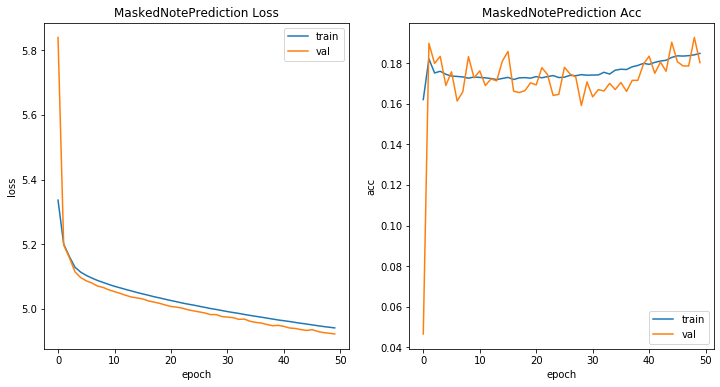

In [31]:
task_num = len(models_trained)
fig, axs = plt.subplots(task_num, 2, figsize=(12, task_num*6))

for m, model in enumerate(models_trained):
    train_loss = model.loss_dict['train']
    val_loss = model.loss_dict['val']
    train_acc = model.acc_dict['train']
    val_acc = model.acc_dict['val']
    x = np.arange(len(train_loss))
    
    if task_num == 1:
        ax_loss = axs[0]
        ax_acc = axs[1]
    else:
        ax_loss = axs[m][0]
        ax_acc = axs[m][1]
        
    ax_loss.plot(x, train_loss, label='train', linewidth=1.5)
    ax_loss.plot(x, val_loss[:len(x)], label='val', linewidth=1.5)
    ax_loss.legend(loc='upper right')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.set_title(f"{model.name} Loss")

    ax_acc.plot(x, train_acc, label='train', linewidth=1.5)
    ax_acc.plot(x, val_acc[:len(x)], label='val', linewidth=1.5)
    ax_acc.legend(loc='lower right')
    ax_acc.set_xlabel('epoch')
    ax_acc.set_ylabel('acc')
    ax_acc.set_title(f"{model.name} Acc")

plt.show()

とりあえずベースライン  
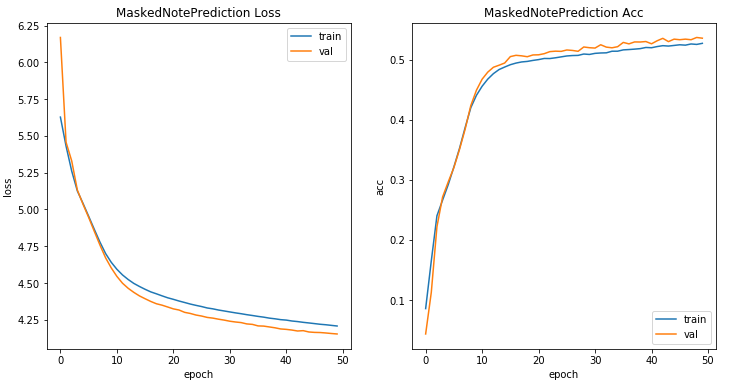

mnp=0.9にしても40%当たるってどういうこと？  
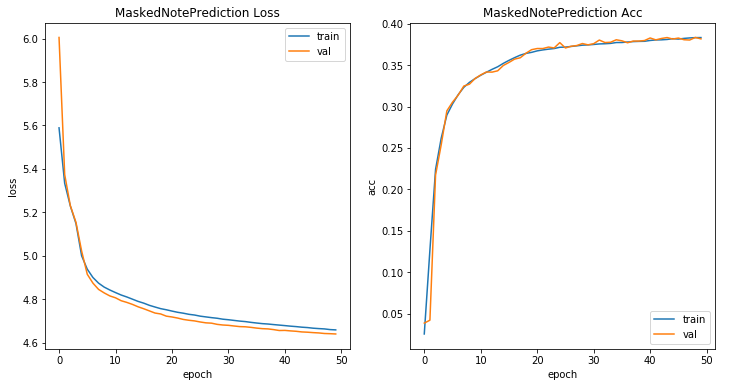

multi headしてbertを4層にしてみたけど大して変わらない  
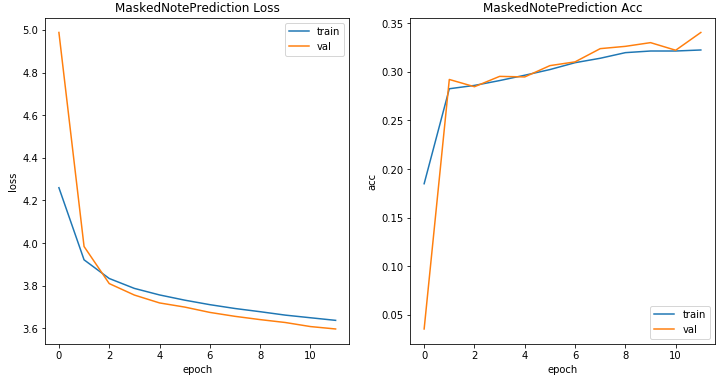

やっぱりhiddenを増やすのが良い  
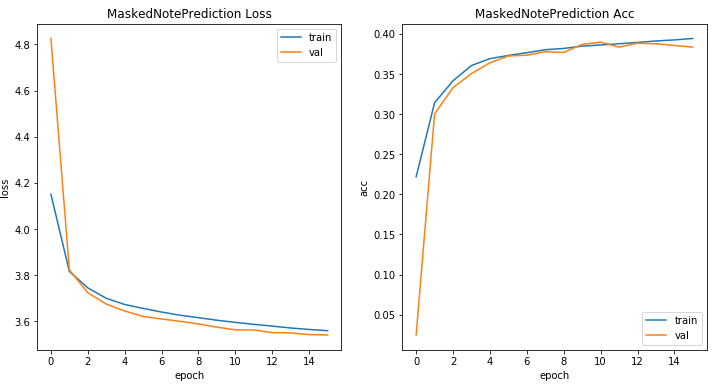

mask rate 1.0のもの  
大体40%に収束  
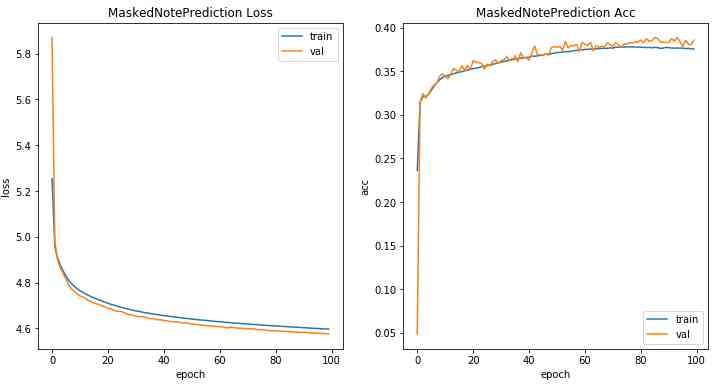

完全にすべてをmaskにした．  
17%という大体1/7=0.14に近い値になった  
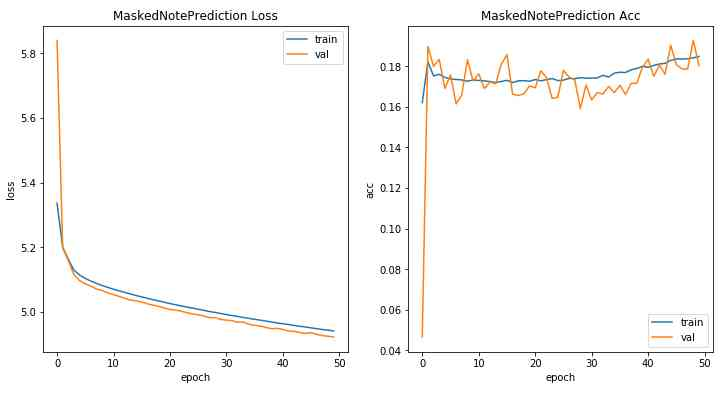

## 事前学習済みモデルの保存と読込み

In [32]:
state_names_dict = save_body(config, body_trained, epoch_num, pretrained_dir)

pre_training_state_names = []
for model_trained in models_trained:
    state_name = save_model(config, model_trained, epoch_num, pretrained_dir)
    pre_training_state_names.append(state_name)

state_names_dict['masked_note_prediction'] = pre_training_state_names[0]

config_file_name = save_config(config, pretrained_dir, state_names_dict=state_names_dict)

schwbert_all_masked:ConditionalEmbeddings:E=050H=128I=512A=2AH=1.pth saved
schwbert_all_masked:BertStack:E=050H=128I=512A=2AH=1.pth saved
schwbert_all_masked:MaskedNotePrediction:E=050H=128I=512A=2AH=1MNP:A=10T=1.0M=1.0R=0.0K=0.0.pth saved
schwbert_all_masked:config@2020-01-19_21:42.json saved


In [33]:
config = load_config(config_file_name, pretrained_dir)

body_trained = load_body(config, pretrained_dir)

models_trained = [
    load_model(
        MaskedNotePrediction(config, body_trained), 
        config.state_names.masked_note_prediction,
        pretrained_dir),
]

## テストデータでのチェック

In [34]:
model = models_trained[0]

device = torch.device("cuda")
model = model.to(device)
# model = MultiGPUWrapper(model)

print(f"Start task using test data by {model.name}")
with Timer():
    test_acc = 0.
    model.eval()
    for batch in dataloaders_dict['test']:
        
        with torch.set_grad_enabled(False):
            batch = model.send(batch, device)
            output = model(batch)
            
            # 評価モード時はlossが出ない．たぶん．
            _, acc = model.get_loss_and_acc(batch, output)
            test_acc += acc

data_num = len(dataloaders_dict['test'].dataset)
batch_num = len(dataloaders_dict['test'])
test_acc /= batch_num

print(f"Accuracy result by {data_num} test data: {test_acc}")

Start task using test data by MaskedNotePrediction
Timer: 1.972030
Accuracy result by 5219 test data: 0.19099244475364685


MNPの実際の予測結果を確認

In [35]:
device = torch.device("cpu")
model = model.to(device)

model.eval()
batch = dataloaders_dict['test']()
print("batch size:", len(batch.melody))

with torch.set_grad_enabled(False):
    batch = model.send(batch, device)
    output, probs = model(batch, get_probs=True)

batch size: 150


mnp steps [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 

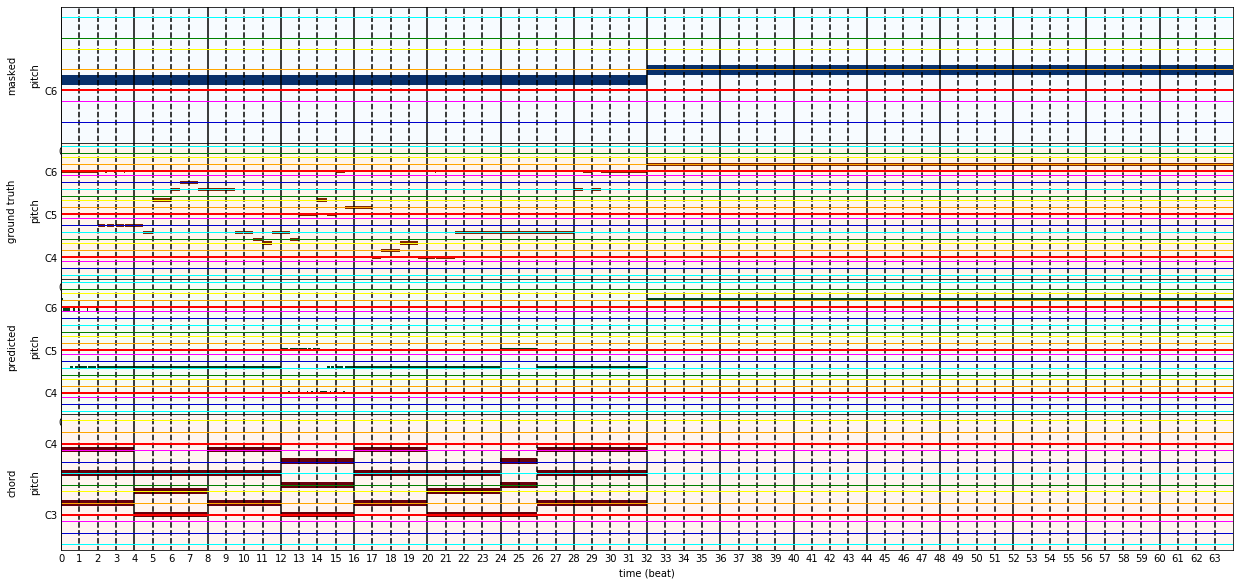

In [39]:
batch_id = 3

bundle = Bundle({
    "melody": batch.melody[batch_id].numpy(),
    "chord": batch.chord[batch_id].numpy(),
    "meta": batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
steps = batch.mnp_steps.numpy()
labels = batch.mnp_labels.numpy()
weights = batch.mnp_weights.numpy()

print("mnp steps", steps[batch_id])
print("\nmnp weights", weights[batch_id].squeeze(-1))

weight_len = weights[batch_id].sum()
print("\nweight len:", weight_len)

ppr = bundle.get_ppr()

ppr.assign_constant(60)
ppr.tracks.insert(1, ppr.tracks[0].copy())
ppr.tracks.insert(1, ppr.tracks[0].copy())

# masked
ppr.tracks[0].pianoroll[steps[batch_id, :weight_len]] *= 2
ppr.tracks[0].name = "masked"

# ground truth
label_ids = np.argmax(labels[batch_id], axis=-1)
print("\nlabels:", label_ids)
offset = batch.meta[batch_id].melody_offset
ppr.tracks[1].pianoroll[steps[batch_id, :weight_len]] *= 0
ppr.tracks[1].pianoroll[steps[batch_id, :weight_len], offset + label_ids[:weight_len]] = 120
ppr.tracks[1].name = "ground truth"

# predicted
_, preds = torch.max(output[batch_id], dim=-1)
preds = preds.numpy()
print("\npredictions:", preds)
offset = batch.meta[batch_id].melody_offset
ppr.tracks[2].pianoroll[steps[batch_id, :weight_len]] *= 0
ppr.tracks[2].pianoroll[steps[batch_id, :weight_len], offset + preds[:weight_len]] = 120
ppr.tracks[2].name = "predicted"

print("\nacc:", (label_ids == preds)[:weight_len].sum().astype(np.float) / weight_len)
grid_plot(ppr)

In [ ]:
probs[0].shape

In [ ]:
entropy = -(probs[0][0][3] * torch.log2(probs[0][0][3]))
entropy[entropy != entropy] = 0
entropy.sum()

繰り返しを捉えるのは得意みたい  
でも繰り返しのないメロディではしくじりがち  
なのでひょっとしたらstepsの方が良いのかも  
地味にコードの構成音も大体使ってるみたい  
でもコードの構成音でない音もたまに当てに行ってるからおそるべし  
MaskedStepPredictionにしたら嘘みたいにACC上がった．  
そもそも人間にも音符丸ごと隠されたらそこに何が入るのか判定するのは難しい  
モデルを大型化すれば，隣り合うMaskには同じ音が入る，くらいは学習できるみたい？

Attentionの可視化もこんな感じで，上に参照元を濃くしたもの，下に参照先の重みに応じた濃さにしたもの，としよう